In [1]:
import os
import xml.etree.ElementTree as ET

def convert_bbox(size, box):
    dw, dh = 1. / size[0], 1. / size[1]
    x_center = ((box[0] + box[1]) / 2.0 - 1) * dw
    y_center = ((box[2] + box[3]) / 2.0 - 1) * dh
    width = (box[1] - box[0]) * dw
    height = (box[3] - box[2]) * dh
    return (x_center, y_center, width, height)

def xml_to_yolo(xml_folder, save_folder, classes):
    os.makedirs(save_folder, exist_ok=True)
    xml_files = [f for f in os.listdir(xml_folder) if f.endswith('.xml')]

    for xml_file in xml_files:
        tree = ET.parse(os.path.join(xml_folder, xml_file))
        root = tree.getroot()
        size = root.find('size')
        w, h = int(size.find('width').text), int(size.find('height').text)
        txt_path = os.path.join(save_folder, xml_file.replace('.xml', '.txt'))

        with open(txt_path, 'w') as f:
            for obj in root.iter('object'):
                cls = obj.find('name').text
                if cls not in classes:
                    continue
                cls_id = classes.index(cls)
                xmlbox = obj.find('bndbox')
                b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text),
                     float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
                bb = convert_bbox((w, h), b)
                f.write(f"{cls_id} {' '.join(map(str, bb))}\n")

    print(f"[XML → YOLO] 변환 완료: {len(xml_files)}개 파일")


In [2]:
classes = ['Firecracker', 'Hammer', 'NailClippers', 'Spanner', 'Thinner', 'ZippoOil']
xml_to_yolo('./project_root/train_annotations', './project_root/labels/train', classes)
xml_to_yolo('.//project_root/val_annotations', './project_root/labels/val', classes)


[XML → YOLO] 변환 완료: 2529개 파일
[XML → YOLO] 변환 완료: 680개 파일


In [2]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [6]:
# data.yaml 내용 문자열로 생성 (경로는 필요에 맞게 수정하세요)
data_yaml_content = """
train: ./train_images
val: ./val_images

nc: 6
names: ['Firecracker', 'Hammer', 'NailClippers', 'Spanner', 'Thinner', 'ZippoOil']
"""

# data.yaml 파일로 저장
with open('data.yaml', 'w') as f:
    f.write(data_yaml_content)

print("data.yaml 파일 생성 완료")



data.yaml 파일 생성 완료


In [3]:
# 모델 구조만 불러오기 (가중치 랜덤 초기화)
model = YOLO('yolov8n.yaml')

# 학습 실행 (epoch, batch size 등은 환경에 맞게 조절)
model.train(
    data='data.yaml',
    epochs=50,
    imgsz=640,
    batch=8,
    project='my_project',
    name='train_from_scratch',
    exist_ok=True,
    pretrained=False  # 사전학습 가중치 사용 안함
)


Ultralytics 8.3.112  Python-3.9.21 torch-2.6.0+cpu CPU (11th Gen Intel Core(TM) i5-1155G7 2.50GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=my_project, name=train_from_scratch, exist_ok=True, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

train: Scanning E:\AI_KDT7\12.Transfer_learning\mini\dataset\train\labels... 2529 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2529/2529 [00:05<00:00, 475.32it/s]


train: New cache created: E:\AI_KDT7\12.Transfer_learning\mini\dataset\train\labels.cache
val: Fast image access  (ping: 0.10.1 ms, read: 26.62.8 MB/s, size: 1240.5 KB)


val: Scanning E:\AI_KDT7\12.Transfer_learning\mini\dataset\val\labels... 680 images, 0 backgrounds, 0 corrupt: 100%|██████████| 680/680 [00:17<00:00, 39.04it/s]

val: New cache created: E:\AI_KDT7\12.Transfer_learning\mini\dataset\val\labels.cache


Plotting labels to my_project\train_from_scratch\labels.jpg... 


: 

In [ ]:
# 검증 실행 (best.pt 가중치 기준)
val_results = model.val()

# val_results는 ultralytics 내부 결과 객체입니다.
print("\n검증 결과 요약:")
print(val_results.metrics)  # precision, recall, mAP 등 주요 지표 출력


In [ ]:
# 혼돈행렬 가져오기 (val_results.confusion_matrix)
cm = val_results.confusion_matrix

# 클래스 이름
class_names = ['Firecracker', 'Hammer', 'NailClippers', 'Spanner', 'Thinner', 'ZippoOil']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# ultralytics val 결과에서 IOU 히스토그램 그리기
ious = val_results.ious  # 각 예측 박스별 IOU 배열

plt.figure(figsize=(8,4))
plt.hist(ious, bins=50, alpha=0.75, color='g')
plt.title('Distribution of IOU values')
plt.xlabel('IOU')
plt.ylabel('Frequency')
plt.show()


[쿠다]

In [1]:
import torch
from ultralytics import YOLO

print(f"CUDA 사용 가능 여부: {torch.cuda.is_available()}")
print(f"사용 디바이스: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU 사용 중'}")


WARNING torchvision==0.20 is incompatible with torch==2.4.
Run 'pip install torchvision==0.19' to fix torchvision or 'pip install -U torch torchvision' to update both.
For a full compatibility table see https://github.com/pytorch/vision#installation
Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\user\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
CUDA 사용 가능 여부: False
사용 디바이스: CPU 사용 중


In [2]:
model = YOLO('yolov5n.yaml')  # 모델 구조만 불러오기 (가중치 없음)

In [5]:
model.train(
    data='data.yaml',
    epochs=10,
    batch=8,
    imgsz=640,
    pretrained=False,   # 가중치 없이 처음부터 학습
    device=0,           # GPU 0번 사용 (CUDA)
    project='my_project',
    name='train_from_scratch_cuda',
    exist_ok=True,
    plots=True
)


Ultralytics 8.3.105  Python-3.9.21 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100 80GB PCIe, 81454MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.yaml, data=data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=my_project, name=train_from_scratch_cuda, exist_ok=True, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

train: Scanning F:\AI_KDT7\12.Transfer_learning\mini\dataset\train\labels.cache... 2529 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2529/2529 [00:00<?, ?it/s]
val: Scanning F:\AI_KDT7\12.Transfer_learning\mini\dataset\val\labels.cache... 680 images, 0 backgrounds, 0 corrupt: 100%|██████████| 680/680 [00:00<?, ?it/s]


Plotting labels to my_project\train_from_scratch_cuda\labels.jpg... 


: 

In [ ]:
results = model.val()

print("평가지표:")
print(results.metrics)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = results.confusion_matrix
class_names = ['Firecracker', 'Hammer', 'NailClippers', 'Spanner', 'Thinner', 'ZippoOil']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('예측 클래스')
plt.ylabel('실제 클래스')
plt.title('혼돈행렬')
plt.show()


In [ ]:
ious = results.ious

plt.figure(figsize=(8,4))
plt.hist(ious, bins=50, color='green', alpha=0.7)
plt.title('IOU 분포')
plt.xlabel('IOU 값')
plt.ylabel('빈도수')
plt.show()


내가 하고자 하는 프로젝트는 공항검색대의 x-ray 사진을 가지고 위험물을 파악하여 이를 객체로 인식해서 바운딩 박스가 나오게 끔 하는거야 
여기서 내가 준비한 클래스의 이름은 ['Firecracker', 'Hammer', 'NailClippers', 'Spanner', 'Thinner' , 'ZippoOil'] 이야
그리고 훈련 데이터 셋이 저장된 폴더와 이 데이터에 대하여 정보가 저장되어 있는 xml 데이터 폴더가 있고
검증용 데이터 셋이 저장되어 있는 폴더와 이 데이터에 대하여 정보가 저장되어 있는 xml 데이터 폴더가 있어 
이를 바탕으로 파이토치의 YOLO5를 사용하여 모델을 만들고자 해 이때에 사용되는 에폭의 수는 5이고 평가지수로는 IoU와 recall, precision, summary(F1, 혼돈행렬)을 활용하고자 해 이때에 하나의 에폭마다 모델을 저장하는데 정확도도 모델 이름에 들어 갔으면 좋겠어 
내가 할 것은 cuda 12.4를 쓸건데 위의 내용을 바탕으로 코드를 짜주고 어떠헌 가상환경을 사용하여야 하는지 알려주라 
발표가 10시간밖에 남지 않았어 제발 도와줘 ㅠㅠ

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'runs/detect/exp/labels'

In [3]:
import torch

# YOLOv5n 모델 로드
model = torch.hub.load('ultralytics/yolov5', 'yolov5n', pretrained=False)

RuntimeError: It looks like there is no internet connection and the repo could not be found in the cache (C:\Users\user/.cache\torch\hub)

In [5]:
def initialize_weights(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)

# 모델의 모든 레이어에 가중치 초기화 적용
model.apply(initialize_weights)

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3(
      (cv1): Conv(
        (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
     

In [6]:
print(model)


DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3(
      (cv1): Conv(
        (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
     

In [7]:
# 옵티마이저 설정
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [12]:
import torch
import os
import yaml
from pathlib import Path
from ultralytics import YOLO  # YOLOv5 모델을 가져옵니다.

# 설정
data_dir = r'F:\AI_KDT7\12.Transfer_learning\mini\dataset'  # 데이터셋 경로
train_images_dir = os.path.join(data_dir, 'train')  # 훈련 이미지 경로
val_images_dir = os.path.join(data_dir, 'val')  # 검증 이미지 경로

# 클래스 이름
class_names = ['Firecracker', 'Hammer', 'NailClippers', 'Spanner', 'Thinner', 'ZippoOil']

# 데이터셋 설정
data_yaml = {
    'train': str(Path(train_images_dir)),
    'val': str(Path(val_images_dir)),
    'nc': len(class_names),
    'names': class_names
}

# YAML 파일로 저장
with open('data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

# YOLOv5 모델 로드
model = YOLO("yolov5n.yaml")  # 모델을 YAML 파일로부터 로드합니다.

# 훈련 설정
epochs = 5
device = 'cuda:0'
print(device)

# 모델 훈련
results = model.train(data='data.yaml', epochs=epochs, imgsz=640, batch=16, device=device)

# 평가
metrics = model.val(data='data.yaml', imgsz=640)

# IoU, Recall, Precision, F1 Score, Confusion Matrix
iou = metrics['metrics']['IoU']
recall = metrics['metrics']['recall']
precision = metrics['metrics']['precision']
f1 = metrics['metrics']['f1']
confusion_matrix = metrics['metrics']['confusion_matrix']

print(f'IoU: {iou:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1: {f1:.4f}')
print(f'Confusion Matrix:\n{confusion_matrix}')

print('Training complete.')


cpu
Ultralytics 8.3.112  Python-3.8.20 torch-2.4.1 CPU (Intel Xeon Gold 6346 3.10GHz)
engine\trainer: task=detect, mode=train, model=yolov5n.yaml, data=data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=

train: Scanning F:\AI_KDT7\12.Transfer_learning\mini\dataset\train\labels.cache... 2529 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2529/2529 [00:00<?, ?it/s]

val: Fast image access  (ping: 0.00.0 ms, read: 2374.1269.0 MB/s, size: 1240.5 KB)



val: Scanning F:\AI_KDT7\12.Transfer_learning\mini\dataset\val\labels.cache... 680 images, 0 backgrounds, 0 corrupt: 100%|██████████| 680/680 [00:00<?, ?it/s]

Plotting labels to runs\detect\train2\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      4.155      7.384       3.77          2        640: 100%|██████████| 159/159 [05:15<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:38<00:00,  1.77s/it]

                   all        680        682    0.00177      0.221    0.00992    0.00246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      2.992      4.486      2.678          2        640: 100%|██████████| 159/159 [05:02<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:35<00:00,  1.61s/it]

                   all        680        682     0.0106      0.254     0.0415     0.0122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      2.671      3.324      2.323          2        640: 100%|██████████| 159/159 [05:00<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:31<00:00,  1.45s/it]

                   all        680        682      0.462      0.298      0.237      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      2.455      2.734      2.145          4        640: 100%|██████████| 159/159 [04:56<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:30<00:00,  1.40s/it]

                   all        680        682      0.357       0.43      0.371       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      2.261      2.383      1.998          4        640: 100%|██████████| 159/159 [05:00<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:32<00:00,  1.46s/it]

                   all        680        682      0.591      0.499      0.543      0.286



5 epochs completed in 0.470 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 5.2MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 5.2MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics 8.3.112  Python-3.8.20 torch-2.4.1 CPU (Intel Xeon Gold 6346 3.10GHz)
YOLOv5n summary (fused): 84 layers, 2,504,114 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:29<00:00,  1.32s/it]


                   all        680        682      0.581      0.499      0.543      0.287
           Firecracker         98         98      0.749      0.133      0.259      0.129
                Hammer         78         78       0.79      0.385      0.586      0.213
          NailClippers         60         60        0.7      0.584      0.674      0.338
               Spanner        414        416      0.535      0.892      0.827      0.432
               Thinner         15         15       0.43        0.6      0.533      0.369
              ZippoOil         15         15      0.283        0.4      0.377      0.239
Speed: 0.6ms preprocess, 11.1ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\train2
Ultralytics 8.3.112  Python-3.8.20 torch-2.4.1 CPU (Intel Xeon Gold 6346 3.10GHz)
YOLOv5n summary (fused): 84 layers, 2,504,114 parameters, 0 gradients, 7.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 2308.8288.0 MB/s, size: 1110.2 KB)


val: Scanning F:\AI_KDT7\12.Transfer_learning\mini\dataset\val\labels.cache... 680 images, 0 backgrounds, 0 corrupt: 100%|██████████| 680/680 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:28<00:00,  1.49it/s]


                   all        680        682      0.581      0.499      0.543      0.287
           Firecracker         98         98      0.749      0.133      0.259      0.129
                Hammer         78         78       0.79      0.385      0.586      0.213
          NailClippers         60         60        0.7      0.584      0.674      0.338
               Spanner        414        416      0.535      0.892      0.827      0.432
               Thinner         15         15       0.43        0.6      0.533      0.369
              ZippoOil         15         15      0.283        0.4      0.377      0.239
Speed: 0.5ms preprocess, 10.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\train22


TypeError: 'DetMetrics' object is not subscriptable

In [13]:
# 평가
metrics = model.val(data='data.yaml', imgsz=640)

# IoU, Recall, Precision, F1 Score, Confusion Matrix
iou = metrics.iou  # IoU 값
recall = metrics.recall  # Recall 값
precision = metrics.precision  # Precision 값
f1 = metrics.f1  # F1 Score 값
confusion_matrix = metrics.confusion_matrix  # 혼동 행렬

print(f'IoU: {iou:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1: {f1:.4f}')
print(f'Confusion Matrix:\n{confusion_matrix}')


Ultralytics 8.3.112  Python-3.8.20 torch-2.4.1 CPU (Intel Xeon Gold 6346 3.10GHz)
val: Fast image access  (ping: 0.10.0 ms, read: 1217.6187.0 MB/s, size: 1195.8 KB)


val: Scanning F:\AI_KDT7\12.Transfer_learning\mini\dataset\val\labels.cache... 680 images, 0 backgrounds, 0 corrupt: 100%|██████████| 680/680 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:29<00:00,  1.44it/s]


                   all        680        682      0.581      0.499      0.543      0.287
           Firecracker         98         98      0.749      0.133      0.259      0.129
                Hammer         78         78       0.79      0.385      0.586      0.213
          NailClippers         60         60        0.7      0.584      0.674      0.338
               Spanner        414        416      0.535      0.892      0.827      0.432
               Thinner         15         15       0.43        0.6      0.533      0.369
              ZippoOil         15         15      0.283        0.4      0.377      0.239
Speed: 0.5ms preprocess, 11.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\train23


AttributeError: 'DetMetrics' object has no attribute 'iou'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class.
        names (dict): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
    

In [15]:
# 모델 평가
metrics = model.val(data='data.yaml', imgsz=640)

# Precision, Recall, mAP
precision = metrics.box.precision  # Precision 값
recall = metrics.box.recall  # Recall 값
map_value = metrics.box.map  # mAP 값

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, mAP: {map_value:.4f}')


Ultralytics 8.3.112  Python-3.8.20 torch-2.4.1 CPU (Intel Xeon Gold 6346 3.10GHz)
val: Fast image access  (ping: 0.10.0 ms, read: 1559.8269.5 MB/s, size: 959.3 KB)


val: Scanning F:\AI_KDT7\12.Transfer_learning\mini\dataset\val\labels.cache... 680 images, 0 backgrounds, 0 corrupt: 100%|██████████| 680/680 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:29<00:00,  1.44it/s]


                   all        680        682      0.581      0.499      0.543      0.287
           Firecracker         98         98      0.749      0.133      0.259      0.129
                Hammer         78         78       0.79      0.385      0.586      0.213
          NailClippers         60         60        0.7      0.584      0.674      0.338
               Spanner        414        416      0.535      0.892      0.827      0.432
               Thinner         15         15       0.43        0.6      0.533      0.369
              ZippoOil         15         15      0.283        0.4      0.377      0.239
Speed: 0.5ms preprocess, 11.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\train25


AttributeError: 'Metric' object has no attribute 'precision'. See valid attributes below.

    Class for computing evaluation metrics for YOLOv8 model.

    Attributes:
        p (list): Precision for each class. Shape: (nc,).
        r (list): Recall for each class. Shape: (nc,).
        f1 (list): F1 score for each class. Shape: (nc,).
        all_ap (list): AP scores for all classes and all IoU thresholds. Shape: (nc, 10).
        ap_class_index (list): Index of class for each AP score. Shape: (nc,).
        nc (int): Number of classes.

    Methods:
        ap50(): AP at IoU threshold of 0.5 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        ap(): AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        mp(): Mean precision of all classes. Returns: Float.
        mr(): Mean recall of all classes. Returns: Float.
        map50(): Mean AP at IoU threshold of 0.5 for all classes. Returns: Float.
        map75(): Mean AP at IoU threshold of 0.75 for all classes. Returns: Float.
        map(): Mean AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: Float.
        mean_results(): Mean of results, returns mp, mr, map50, map.
        class_result(i): Class-aware result, returns p[i], r[i], ap50[i], ap[i].
        maps(): mAP of each class. Returns: Array of mAP scores, shape: (nc,).
        fitness(): Model fitness as a weighted combination of metrics. Returns: Float.
        update(results): Update metric attributes with new evaluation results.
    

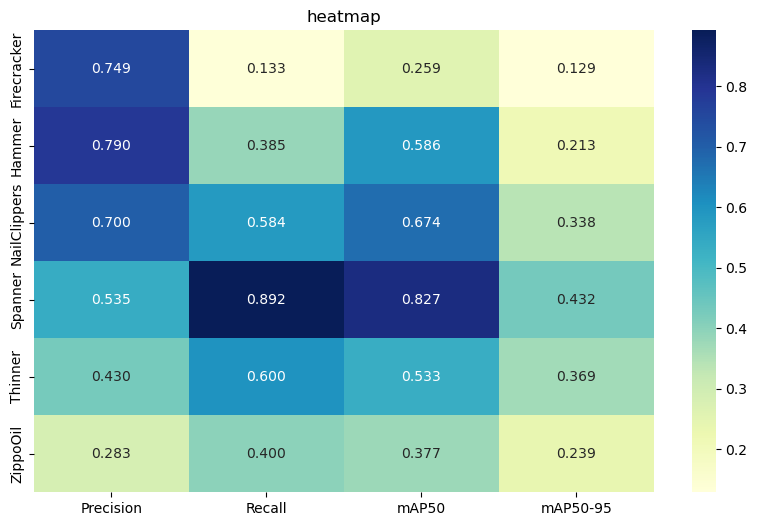

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 데이터 준비
data = {
    'Precision': [0.749, 0.790, 0.700, 0.535, 0.430, 0.283],
    'Recall': [0.133, 0.385, 0.584, 0.892, 0.600, 0.400],
    'mAP50': [0.259, 0.586, 0.674, 0.827, 0.533, 0.377],
    'mAP50-95': [0.129, 0.213, 0.338, 0.432, 0.369, 0.239]
}
classes = ['Firecracker', 'Hammer', 'NailClippers', 'Spanner', 'Thinner', 'ZippoOil']

df = pd.DataFrame(data, index=classes)

# 히트맵 그리기
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap='YlGnBu', fmt=".3f")
plt.title("heatmap")
plt.show()


In [2]:
!pip install ultralytics 

  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
   ---------------------------------------- 0.0/982.4 kB ? eta -:--:--
   --------------------------------------- 982.4/982.4 kB 15.3 MB/s eta 0:00:00
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)


In [1]:
import torch
import os
import yaml
from pathlib import Path
from ultralytics import YOLO  # YOLOv5 모델을 가져옵니다.

# 설정
data_dir = r'F:\AI_KDT7\12.Transfer_learning\mini\dataset'  # 데이터셋 경로
train_images_dir = os.path.join(data_dir, 'train')  # 훈련 이미지 경로
val_images_dir = os.path.join(data_dir, 'val')  # 검증 이미지 경로

# 클래스 이름
class_names = ['Firecracker', 'Hammer', 'NailClippers', 'Spanner', 'Thinner', 'ZippoOil']

# 데이터셋 설정
data_yaml = {
    'train': str(Path(train_images_dir)),
    'val': str(Path(val_images_dir)),
    'nc': len(class_names),
    'names': class_names
}

# YAML 파일로 저장
with open('data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

# YOLOv5 모델 로드
model = YOLO("yolov5n.yaml")  # 모델을 YAML 파일로부터 로드합니다.

# 훈련 설정
epochs = 5
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# 모든 가중치 고정 해제
for param in model.parameters():
    param.requires_grad = True  # 모든 가중치 학습 가능하도록 설정

# 모델 훈련
results = model.train(data='data.yaml', epochs=epochs, imgsz=640, batch=16, device=device)

Using device: cpu
New https://pypi.org/project/ultralytics/8.3.113 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.112  Python-3.8.20 torch-2.4.1+cpu CPU (Intel Core(TM) Ultra 9 285K)
engine\trainer: task=detect, mode=train, model=yolov5n.yaml, data=data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_tx

train: Scanning F:\AI_KDT7\12.Transfer_learning\mini\dataset\train\labels.cache... 2529 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2529/2529 [00:00<?, ?it/s]

val: Fast image access  (ping: 0.00.0 ms, read: 3303.5474.9 MB/s, size: 1240.5 KB)



val: Scanning F:\AI_KDT7\12.Transfer_learning\mini\dataset\val\labels.cache... 680 images, 0 backgrounds, 0 corrupt: 100%|██████████| 680/680 [00:00<?, ?it/s]


Plotting labels to runs\detect\train9\labels.jpg... 


: 

In [ ]:
# 평가
metrics = model.val(data='data.yaml', imgsz=640)

# IoU, Recall, Precision, F1 Score, Confusion Matrix
iou = metrics['metrics']['IoU']
recall = metrics['metrics']['recall']
precision = metrics['metrics']['precision']
f1 = metrics['metrics']['f1']
confusion_matrix = metrics['metrics']['confusion_matrix']

print(f'IoU: {iou:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1: {f1:.4f}')
print(f'Confusion Matrix:\n{confusion_matrix}')

print('Training complete.')